# Mean reverting strategy based on Bollinger bands Strategy

This notebook answers question 3.5 form the text book Advances in Financial Machine Learning.

3.5 Develop a mean-reverting strategy based on Bollinger bands. For each observation, the model suggests a side, but not a size of the bet.

* (a) Derive meta-labels for ptSl = [0, 2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
* (b) Train a random forest to decide whether to trade or not. Use as features: volatility, seial correlation, and teh crossinmg moving averages.
* (c) What is teh accuracy of prediction from the primary model? (i.e. if the secondary model does not filter the bets) What are the precision, recall and FI-scores?
* (d) What is teh accuracy of prediction from the primary model? What are the precision, recall and FI-scores?


In [1]:
import numpy as np
import pandas as pd
import pyfolio as pf
import timeit

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

from mlfinlab.corefns.core_functions import CoreFunctions
from mlfinlab.corefns.financial_functions import FinancialFunctions 
from mlfinlab.util.utils import get_daily_returns

import matplotlib.pyplot as plt
%matplotlib inline

### Read in Data
We are using the dollar bars based off of the high quality HFT data we purchased. There is a sample of bars available in this branch as well. 

In [2]:
# Read in data
data = pd.read_csv('official_data/dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

---
### Define helper functions

In [3]:
# Compute RSI
def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = FinancialFunctions.relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

---
### Fit a Primary Model: Mean-reverting based on Bollinger bands
Based on the mean-reverting Bollinger band strategy.


In [4]:
# compute bands
window = 50
data['avg'], data['upper'], data['lower'] = FinancialFunctions.bbands(data['close'], window, no_of_stdev=1.5)
data.sample(10)

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower
date_time,,,,,,,,,,
2014-11-13 16:08:49.204,2041.25,2041.25,2038.00,2038.00,34316,70002033.25,8778,2036.956064,2043.338734,2030.573394
2012-05-29 19:44:41.324,1328.00,1331.25,1326.25,1331.25,52689,70010664.50,12847,1324.574536,1332.476766,1316.672307
2017-08-29 13:51:49.422,2435.00,2435.50,2433.50,2435.00,29212,71113826.25,2840,2435.611820,2446.597523,2424.626117
2016-05-19 14:00:15.907,2029.75,2030.25,2025.00,2025.50,34529,70001828.50,3428,2039.312448,2049.278427,2029.346469
2017-07-11 19:33:49.153,2424.75,2427.25,2424.25,2426.75,28869,70028795.25,2673,2421.843769,2427.972229,2415.715309
2012-11-15 15:40:55.236,1353.50,1356.00,1353.00,1353.50,51681,70000915.50,13625,1358.525351,1370.618752,1346.431950
2017-06-30 19:59:16.146,2423.50,2424.00,2422.50,2423.00,29171,70688183.50,1103,2423.248761,2429.634845,2416.862676
2014-04-25 13:55:46.607,1863.50,1865.25,1862.00,1865.00,37568,70005480.75,12085,1870.190876,1876.559666,1863.822085
2015-07-07 14:34:10.695,2044.25,2045.00,2043.00,2043.00,34247,70004679.00,3581,2057.226938,2070.486827,2043.967049


In [5]:
# Compute RSI
rsi_df = get_rsi(data, window=14)
data['rsi'] = pd.Series(data=rsi_df.values, index=data.index)

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

---
### Fit a Primary Model: Bollinger Band Mean-Reversion

In [6]:
# Compute sides
data['side'] = np.nan 

long_signals = (data['close'] <= data['lower']) 
short_signals = (data['close'] >= data['upper']) 

data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

print(data.side.value_counts())

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)

 1.0    4242
-1.0    3989
Name: side, dtype: int64


In [7]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [8]:
print(data.side.value_counts())

 1.0    4242
-1.0    3989
Name: side, dtype: int64


### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered. Use the signal from the MAvg Strategy to determine the side of the bet.

In [9]:
# Compute daily volatility
daily_vol = CoreFunctions.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = CoreFunctions.get_t_events(data['close'], threshold=daily_vol['2011-09-01':'2018-01-01'].mean() * 0.1)

# Compute vertical barrier
vertical_barriers = CoreFunctions.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

Calculating daily volatility for dynamic thresholds
Applying Symmetric CUSUM filter.


100%|█████████████████████████████████████████████████████████████████████████████████| 8229/8229 [00:01<00:00, 6909.31it/s]


In [10]:
pt_sl = [0, 2]
min_ret = 0.0005
triple_barrier_events = CoreFunctions.get_events(close=data['close'],
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=min_ret,
                                  num_threads=2,
                                  vertical_barrier_times=vertical_barriers,
                                  side=data['side'])

D:\Documents\WQU\Courses\14 - Capstone 690\chap3\research\Chapter3\mlfinlab\corefns\core_functions.py:205: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-03-16 18:41:32.705493 100.0% apply_pt_sl_on_t1 done after 0.11 minutes. Remaining 0.0 minutes.


In [11]:
labels = CoreFunctions.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

 1.0    2558
-1.0    2084
Name: side, dtype: int64

---
### Results of Primary Model:
What is the accuracy of predictions from the primary model (i.e., if the secondary model does not filter the bets)? Compute the precision, recall, and F1-scores?

In [12]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

c:\users\asingh\anaconda3\envs\cap\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3785
           1       0.18      1.00      0.31       857

   micro avg       0.18      0.18      0.18      4642
   macro avg       0.09      0.50      0.16      4642
weighted avg       0.03      0.18      0.06      4642

Confusion Matrix
[[   0 3785]
 [   0  857]]

Accuracy
0.1846186988367083


**A few takeaways**
* There is an imbalance in the classes - far more are classified as "no trade"
* Meta-labeling says that there are many false-positives  
* the sklearn's confusion matrix is [[TN, FP][FN, TP]] 

---
## Fit a Meta Model
Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

Create the following features: 
* Volatility
* Serial Correlation
* The returns at the different lags from the serial correlation
* The sides from the SMavg Strategy

In [13]:
raw_data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower,rsi,side
date_time,,,,,,,,,,,,
2011-08-01 13:56:56.220,1293.25,1294.00,1292.00,1292.25,54159,70025279.50,12010,1300.315764,1307.910651,1292.720876,13.0,NaN
2011-08-01 14:00:21.448,1292.25,1292.75,1286.75,1286.75,54266,70000564.25,10157,1299.136791,1308.500955,1289.772626,9.0,1.0
2011-08-01 14:01:38.747,1286.75,1287.00,1284.00,1284.50,54475,70034099.00,8778,1297.922642,1308.843635,1287.001649,7.0,1.0
2011-08-01 14:03:22.782,1284.50,1285.00,1278.75,1279.00,54589,70000494.25,10823,1296.418749,1309.539297,1283.298202,5.0,1.0
2011-08-01 14:04:31.604,1279.00,1281.50,1276.00,1276.00,55049,70397187.25,10651,1294.858757,1309.982621,1279.734893,5.0,1.0


### Features

In [14]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()


In [15]:
# Add Trending signals
raw_data['sma'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'sma'] = 1
raw_data.loc[short_signals, 'sma'] = -1

In [16]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['close'] <= raw_data['lower'] 
short_signals = raw_data['close'] >= raw_data['upper'] 

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [17]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

#### Now get the data at the specified events

In [18]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['avg', 'upper', 'lower', 'open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']
X.head()

,rsi,side,log_ret,mom1,mom2,mom3,mom4,mom5,volatility,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5,sma
2011-08-02 17:02:16.995,16.0,1.0,-0.000990,-0.000990,-0.004339,-0.005516,-0.006299,-0.004732,0.001709,-0.024846,0.030397,-0.055224,0.226567,0.122310,-0.003359,-0.001183,-0.000788,0.001576,-0.000591,-1.0
2011-08-02 18:06:11.084,19.0,1.0,-0.002381,-0.002379,-0.002971,-0.005533,-0.005925,-0.005336,0.001762,-0.012131,0.013186,-0.193096,0.241242,0.083327,-0.000594,-0.002572,-0.000395,0.000593,0.002374,-1.0
2011-08-02 19:45:56.176,25.0,1.0,-0.002390,-0.002387,-0.002387,-0.003180,-0.005355,-0.007717,0.001723,0.026686,-0.181886,-0.124395,0.193267,-0.017387,0.000000,-0.000795,-0.002184,-0.002377,0.001188,-1.0
2011-08-03 14:37:04.871,24.0,1.0,-0.002624,-0.002620,-0.004627,-0.003424,-0.006625,-0.009013,0.001713,0.034175,-0.134653,-0.011515,-0.083964,-0.118366,-0.002014,0.001208,-0.003217,-0.002406,-0.001601,-1.0
2011-08-03 14:44:34.209,17.0,1.0,0.000000,0.000000,-0.001014,-0.004244,-0.006853,-0.008851,0.001704,0.072997,-0.083414,-0.002388,-0.028741,-0.036896,-0.001014,-0.003239,-0.002624,-0.002014,0.001208,-1.0


### Fit a model

In [19]:
# Split data into training, validation and test sets
X_training_validation = X['2011-09-01':'2018-01-01']
y_training_validation = y['2011-09-01':'2018-01-01']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)

In [20]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

0    2385
1     531
Name: bin, dtype: int64

In [21]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    2385
0    2385
Name: bin, dtype: int64

In [22]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

In [23]:
# Random Forest Model
n_estimator = 1000
c_random_state = 42
depth = 2

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#### Training Metrics

              precision    recall  f1-score   support

           0       0.61      0.60      0.61      2385
           1       0.61      0.62      0.61      2385

   micro avg       0.61      0.61      0.61      4770
   macro avg       0.61      0.61      0.61      4770
weighted avg       0.61      0.61      0.61      4770

Confusion Matrix
[[1441  944]
 [ 913 1472]]

Accuracy
0.610691823899371


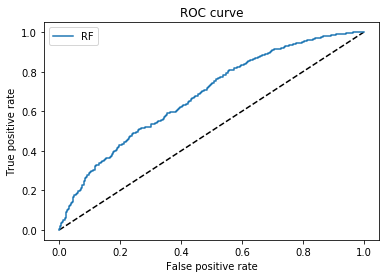

In [24]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Validation Metrics

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       578
           1       0.37      0.31      0.34       151

   micro avg       0.75      0.75      0.75       729
   macro avg       0.60      0.59      0.59       729
weighted avg       0.73      0.75      0.74       729

Confusion Matrix
[[498  80]
 [104  47]]

Accuracy
0.747599451303155


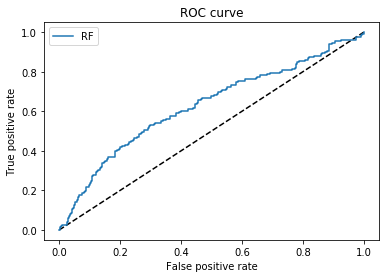

In [25]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

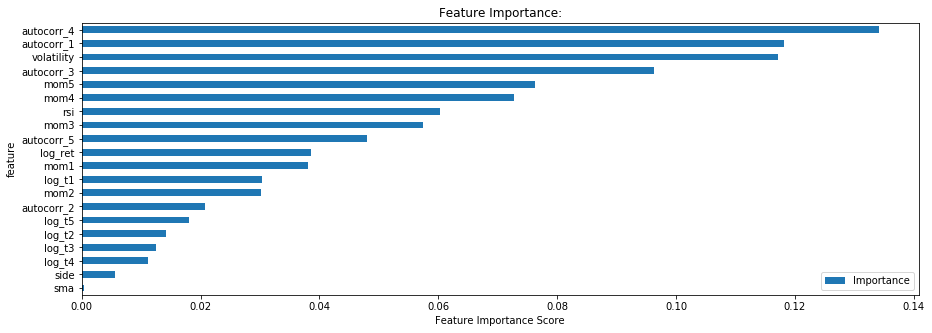

In [26]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

Note how low the side is ranked.

---
## Performance Tear Sheets (In-sample)

In [27]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [28]:
test_dates = X_validate.index

base_rets = labels.loc[test_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(labels.loc[test_dates, 'ret'])

Start date,2016-08-01
End date,2017-12-29
Total months,34
,Backtest
Annual return,58.3%
Cumulative returns,277.3%
Annual volatility,15.3%
Sharpe ratio,3.07
Calmar ratio,2.46
Stability,0.90
Max drawdown,-23.6%


In [29]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

# pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None)
pf.show_perf_stats(daily_meta_rets)

c:\users\asingh\anaconda3\envs\cap\lib\site-packages\empyrical\stats.py:1511: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Start date,2016-08-02
End date,2017-12-29
Total months,17
,Backtest
Annual return,76.7%
Cumulative returns,130.1%
Annual volatility,40.6%
Sharpe ratio,1.56
Calmar ratio,9.77
Stability,0.78
Max drawdown,-7.8%


---
## Perform out-of-sample test

In [30]:
# extarct data for out-of-sample (OOS)
X_oos = X['2018-01-02':]
y_oos = y['2018-01-02':]

              precision    recall  f1-score   support

           0       0.85      0.54      0.66       749
           1       0.19      0.54      0.28       151

   micro avg       0.54      0.54      0.54       900
   macro avg       0.52      0.54      0.47       900
weighted avg       0.74      0.54      0.60       900

Confusion Matrix
[[403 346]
 [ 70  81]]

Accuracy
0.5377777777777778


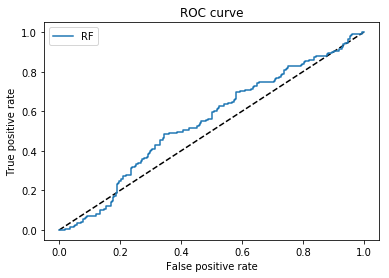

In [31]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_oos)[:, 1]
y_pred = rf.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

---
## Performance Tear Sheets (Out-of-sample)

In [32]:
test_dates = X_oos.index

base_rets_oos = labels.loc[test_dates, 'ret']
primary_model_rets_oos = get_daily_returns(base_rets_oos)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets_oos, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Primary Model OOS'] = perf_stats_all


# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(primary_model_rets_oos)

Start date,2018-01-04
End date,2019-01-28
Total months,13
,Backtest
Annual return,17.7%
Cumulative returns,19.7%
Annual volatility,95.0%
Sharpe ratio,0.65
Calmar ratio,0.29
Stability,0.16
Max drawdown,-61.9%


Start date,2018-01-04
End date,2019-01-28
Total months,13
,Backtest
Annual return,24.0%
Cumulative returns,26.7%
Annual volatility,72.8%
Sharpe ratio,0.67
Calmar ratio,0.46
Stability,0.41
Max drawdown,-52.4%


c:\users\asingh\anaconda3\envs\cap\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,52.38,2018-11-08,2018-12-24,NaT,NaN
1,41.71,2018-01-29,2018-02-05,2018-04-06,50
2,11.81,2018-10-03,2018-10-10,2018-10-12,8
3,10.79,2018-10-17,2018-10-24,2018-10-29,9
4,5.73,2018-06-20,2018-06-25,2018-07-02,9


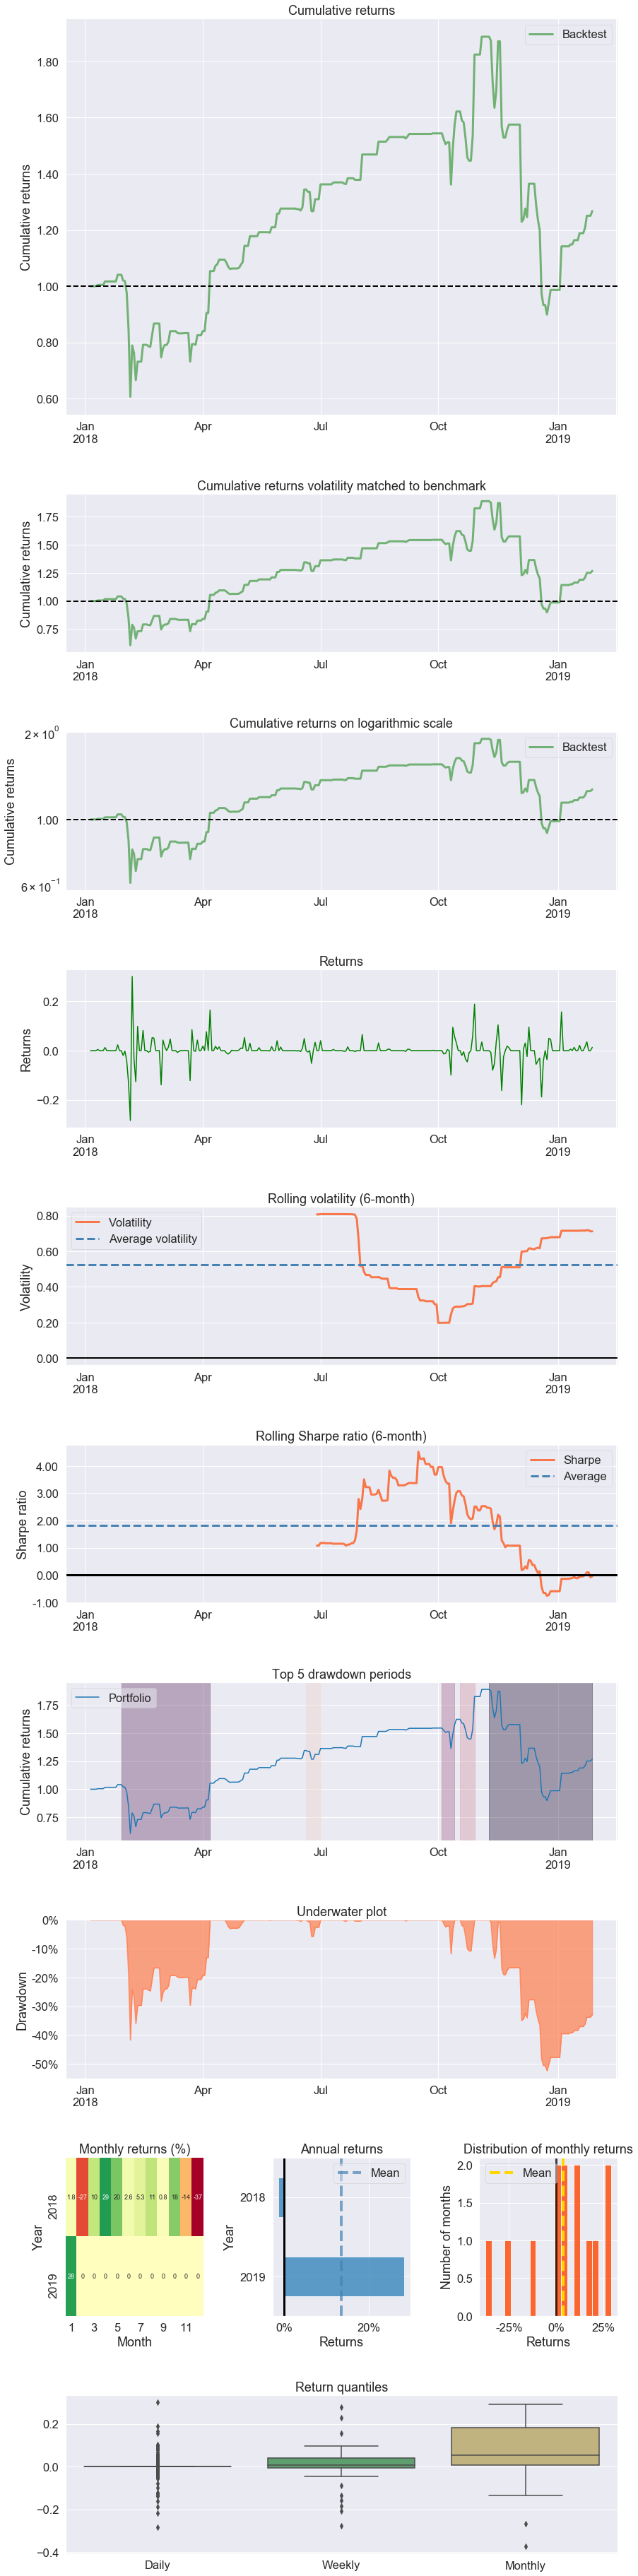

In [33]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_rets_meta, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model OOS'] = perf_stats_all

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

---
### Use PCA to shrink the predictor space

In [34]:
# standardize the data
scaler = StandardScaler()

# fit the training set only
scaler.fit(X_train)

# Apply the transform to both training and test sets
X_train_std = scaler.transform(X_train)
X_validate_std = scaler.transform(X_validate)

# make an instance of the PCA model with 95% coverage
pca = PCA(0.95)

# fit teh PCA model
pca.fit(X_train_std)
print(pca.n_components_)

# transform both training and test sets
X_train_pca = pca.transform(X_train_std)
X_validate_pca = pca.transform(X_validate_std)

12


In [35]:
# Apply RF 
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train_pca, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Training Metrics (PCA)

              precision    recall  f1-score   support

           0       0.70      0.48      0.57      2385
           1       0.60      0.80      0.69      2385

   micro avg       0.64      0.64      0.64      4770
   macro avg       0.65      0.64      0.63      4770
weighted avg       0.65      0.64      0.63      4770

Confusion Matrix
[[1135 1250]
 [ 477 1908]]

Accuracy
0.6379454926624738


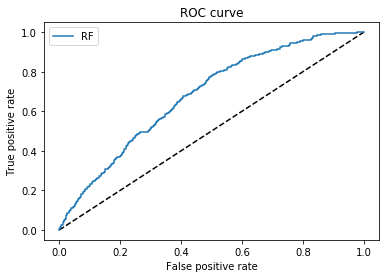

In [36]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train_pca)[:, 1]
y_pred = rf.predict(X_train_pca)

fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Test Metrics (PCA)

              precision    recall  f1-score   support

           0       0.80      0.44      0.57       578
           1       0.21      0.58      0.31       151

   micro avg       0.47      0.47      0.47       729
   macro avg       0.51      0.51      0.44       729
weighted avg       0.68      0.47      0.51       729

Confusion Matrix
[[253 325]
 [ 63  88]]

Accuracy
0.46776406035665297


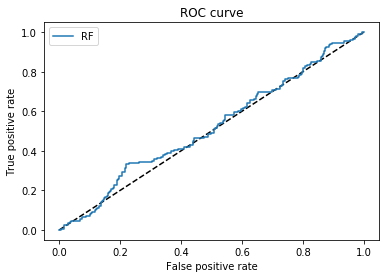

In [37]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate_pca)[:, 1]
y_pred = rf.predict(X_validate_pca)

fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

---
## Performance Tear Sheets PCA

In [38]:
test_dates = X_validate.index

rets = labels.loc[test_dates, 'ret']
daily_rets = get_daily_returns(rets)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['PCA Primary'] = perf_stats_all

# print(pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret']))
pf.show_perf_stats(labels.loc[test_dates, 'ret'])

Start date,2016-08-01
End date,2017-12-29
Total months,34
,Backtest
Annual return,58.3%
Cumulative returns,277.3%
Annual volatility,15.3%
Sharpe ratio,3.07
Calmar ratio,2.46
Stability,0.90
Max drawdown,-23.6%


In [39]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['PCA Meta Model'] = perf_stats_all

# print(pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None))
pf.show_perf_stats(daily_meta_rets)

Start date,2016-08-02
End date,2017-12-29
Total months,17
,Backtest
Annual return,65.6%
Cumulative returns,109.3%
Annual volatility,31.2%
Sharpe ratio,1.76
Calmar ratio,4.96
Stability,0.83
Max drawdown,-13.2%


---
## PCA Out-of-Sample

              precision    recall  f1-score   support

           0       0.85      0.42      0.56       749
           1       0.18      0.62      0.28       151

   micro avg       0.46      0.46      0.46       900
   macro avg       0.51      0.52      0.42       900
weighted avg       0.73      0.46      0.52       900

Confusion Matrix
[[316 433]
 [ 57  94]]

Accuracy
0.45555555555555555


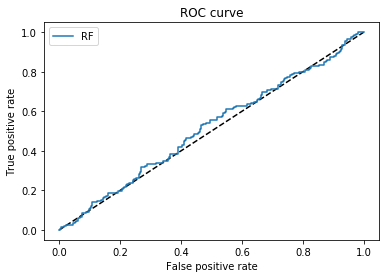

In [40]:
# Apply the transform to both training and test sets
X_oos_std = scaler.transform(X_oos)

# transform both training and test sets
X_oos_pca = pca.transform(X_oos_std)

# Performance Metrics
y_pred_rf = rf.predict_proba(X_oos_pca)[:, 1]
y_pred = rf.predict(X_oos_pca)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

---
## Performance Tear Sheets PCA (Out-of-sample)

In [41]:
test_dates = X_oos.index

rets = labels.loc[test_dates, 'ret']
daily_rets = get_daily_returns(rets)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=daily_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Primary Model PCA OOS'] = perf_stats_all

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(daily_rets)

Start date,2018-01-04
End date,2019-01-28
Total months,13
,Backtest
Annual return,17.7%
Cumulative returns,19.7%
Annual volatility,95.0%
Sharpe ratio,0.65
Calmar ratio,0.29
Stability,0.16
Max drawdown,-61.9%


Start date,2018-01-04
End date,2019-01-28
Total months,13
,Backtest
Annual return,4.7%
Cumulative returns,5.2%
Annual volatility,59.2%
Sharpe ratio,0.39
Calmar ratio,0.10
Stability,0.29
Max drawdown,-46.7%


c:\users\asingh\anaconda3\envs\cap\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,46.73,2018-11-05,2018-12-21,NaT,NaN
1,45.48,2018-01-29,2018-03-22,2018-06-27,108
2,14.10,2018-10-03,2018-10-10,2018-10-29,19
3,4.29,2018-08-23,2018-08-27,2018-09-26,25
4,4.17,2018-07-02,2018-07-27,2018-08-02,24


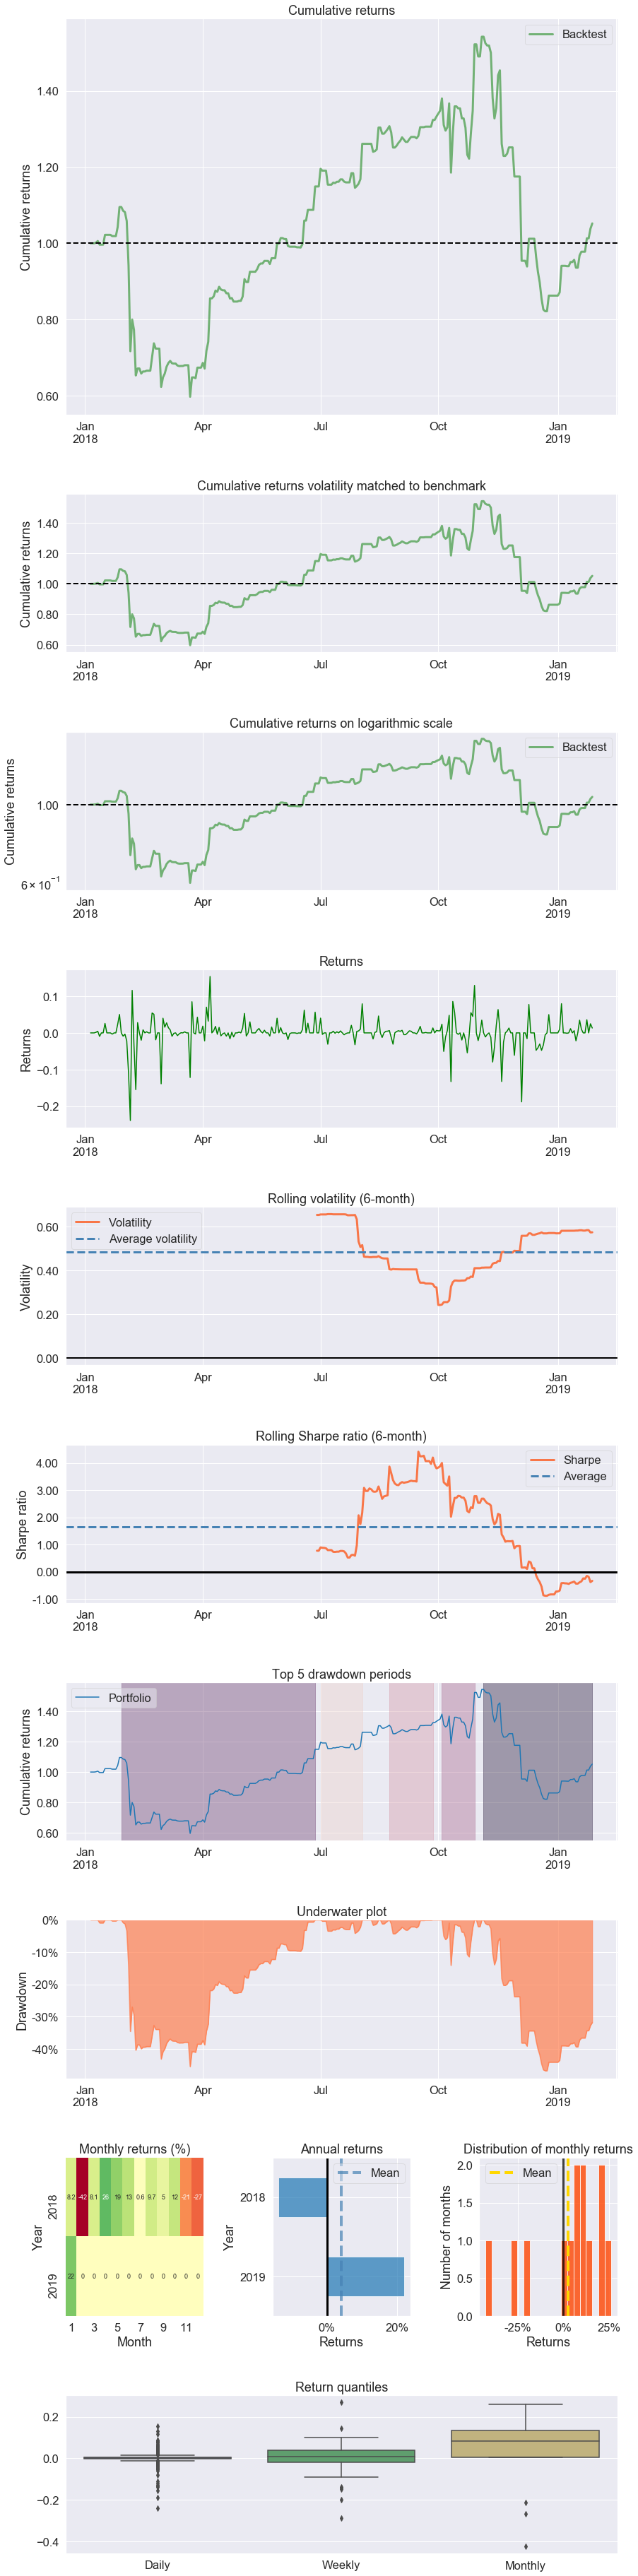

In [42]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model PCA OOS'] = perf_stats_all

pf.create_returns_tear_sheet(daily_meta_rets, benchmark_rets=None)

---
## Save the KPIs in a csv file

In [43]:
# Save the KPIs into a csv file
perf_stats_df.to_csv('BBands_KPI.csv')

---
## Conclusion
We observe that in case of Bollinger bands mean-reverting strategy, the meta-labeling process loses some upside (lower annualized return 43% v. 58%) but helps reduce the risk (from 15.4% to 12.8%) in the strategy compared to the primary model. The maximum drawdown falls from 23.6% to 12.3%. The net result is that Sharpe ratio of meta-model (2.85) is lower than that of the Primary model (3.05). The out-of-sample test is run on the last 13 months of the data (from Jan 3, 2018 to Jan 28, 2019). The annualized returns in the data unseen by the model is 2.9% (volatility 23.3% and Sharpe of 0.238). The meta-model helps increase the annualized returns to 8.6% (at the volatility of 18% and Sharpe of 0.55).  This shows that meta-model has beneficial to the performance.    

We also created a PCA variant of this strategy to reduce the dimensionaloity of the feature-set by taking 95% of the variance. Although the Primary model's performance is identifdical to that of the regular model, the meta-model's annualized returns were ~20% (at 9.5% volatility and a Sharpe of 1.93). In the out-of-sample, the primary model's annualzied return come out to be 2.9% (at a volatility of 23.3% and a Sharpe of 0.238).  The meta-model's annualized return was up by 20 bps (at a volatility of 17.6% and a Sharpe of 0.1.       

There are three conclusions:
- Meta-model helps with risk-adjusted performance in all the cases
- The out-of-sample test has positive performance but is considerably lower than those of validation set
- PCA based model's risk-adjusted performance is considerably weaker than that of regular implementation